### Dependencies

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import math
from sklearn.ensemble import AdaBoostRegressor

### Data

In [24]:
data = pd.read_csv('data/yield_df.csv')

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     28242 non-null  int64  
 1   Area                           28242 non-null  object 
 2   Item                           28242 non-null  object 
 3   Year                           28242 non-null  int64  
 4   hg/ha_yield                    28242 non-null  int64  
 5   average_rain_fall_mm_per_year  28242 non-null  float64
 6   pesticides_tonnes              28242 non-null  float64
 7   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.7+ MB


In [26]:
data.head(10)

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37
5,5,Albania,Wheat,1990,30197,1485.0,121.0,16.37
6,6,Albania,Maize,1991,29068,1485.0,121.0,15.36
7,7,Albania,Potatoes,1991,77818,1485.0,121.0,15.36
8,8,Albania,"Rice, paddy",1991,28538,1485.0,121.0,15.36
9,9,Albania,Sorghum,1991,6667,1485.0,121.0,15.36


In [27]:
data = data.drop('Unnamed: 0', axis=1)

#### TableOne

In [29]:
from tableone import TableOne
columns = ['Item','hg/ha_yield','average_rain_fall_mm_per_year','pesticides_tonnes','avg_temp']
categorical = ['Item']
mytable = TableOne(data, columns, categorical)
print(mytable.tabulate(tablefmt="github"))
mytable.to_csv('tableone.csv')

|                                          |                      | Missing   | Overall           |
|------------------------------------------|----------------------|-----------|-------------------|
| n                                        |                      |           | 28242             |
| Item, n (%)                              | Cassava              | 0         | 2045 (7.2)        |
|                                          | Maize                |           | 4121 (14.6)       |
|                                          | Plantains and others |           | 556 (2.0)         |
|                                          | Potatoes             |           | 4276 (15.1)       |
|                                          | Rice, paddy          |           | 3388 (12.0)       |
|                                          | Sorghum              |           | 3039 (10.8)       |
|                                          | Soybeans             |           | 3223 (11.4)       |


In [30]:
# label encoding
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
le = LabelEncoder()
data['Item'] = le.fit_transform(data['Item'])
data['Area'] = le.fit_transform(data['Area'])

In [31]:
# scaling features
scaler = MinMaxScaler()
cols_to_scale = ['average_rain_fall_mm_per_year','pesticides_tonnes','avg_temp']
data[cols_to_scale]=scaler.fit_transform(data[cols_to_scale])

#### Save processed dataframe to csv

In [86]:
data.to_csv('crop_yield.csv')

### Evaluating Generalizability between years

In [32]:
# generate subset for potatoes
potatoes = data.loc[data['Item'] == 3]
# Generate a subset for 1990-1993
p90 = potatoes.loc[(potatoes['Year'] >= 1990) & (potatoes['Year'] <=1993)]
# Generate a subset for 2010-2013
p10 = potatoes.loc[(potatoes['Year'] >= 2010) & (potatoes['Year'] <=2013)]

In [33]:
# train, test split
p90_X, p90_y = p90.loc[:, p90.columns != 'hg/ha_yield'], p90['hg/ha_yield']
p90_X_train, p90_X_test, p90_y_train, p90_y_test = train_test_split(p90_X,p90_y,test_size=0.2, random_state=42)
p10_X, p10_y = p10.loc[:, p10.columns != 'hg/ha_yield'], p10['hg/ha_yield']
p10_X_train, p10_X_test, p10_y_train, p10_y_test = train_test_split(p10_X,p10_y,test_size=0.2, random_state=42)

In [38]:
# models creation and training
# model 
p90_model = AdaBoostRegressor(n_estimators=50, random_state=42)
# 1990-1993 training
p90_model.fit(p90_X_train, p90_y_train)
# 2010-2013 training
p10_model = AdaBoostRegressor(n_estimators=50, random_state=42)
p10_model.fit(p10_X_train, p10_y_train)

AdaBoostRegressor(random_state=42)

In [39]:
# Models prediction
p90_y_pred = p90_model.predict(p90_X_test)
p10_y_pred = p10_model.predict(p10_X_test)
# model evaluation on same set test
print(f'r2:{r2_score(p90_y_test, p90_y_pred)}, RMSE:{math.pow(mean_squared_error(p90_y_test, p90_y_pred),0.5)}')
print(f'r2:{r2_score(p10_y_test, p10_y_pred)}, RMSE:{math.pow(mean_squared_error(p10_y_test, p10_y_pred),0.5)}')

r2:0.6651419744398708, RMSE:42226.930732313085
r2:0.7069652035446918, RMSE:49048.022734010934


In [43]:
# Cross evaluation
# Models prediction
p90_y_pred_p10 = p90_model.predict(p10_X_test)
p10_y_pred_p90 = p10_model.predict(p90_X_test)
# model evaluation on other set test
print(f'r2:{r2_score(p10_y_test, p90_y_pred_p10)}, RMSE:{math.pow(mean_squared_error(p10_y_test, p90_y_pred_p10),0.5)}')
print(f'r2:{r2_score(p90_y_test, p10_y_pred_p90)}, RMSE:{math.pow(mean_squared_error(p90_y_test, p10_y_pred_p90),0.5)}')

r2:0.0957317871666592, RMSE:86160.96211251832
r2:-0.21651002832267574, RMSE:80485.38141065408


In [46]:
# save subset
p10.to_csv('p10.csv')

### Initial Experiment

#### Under sampled dataframe to csv

In [89]:
# undersample only potatoes, only last 2 years
data = data.loc[data['Item'] == 3]
data = data.loc[data['Year'] >= 2010]

In [41]:
# model training
X,y = data.loc[:, data.columns != 'hg/ha_yield'], data['hg/ha_yield']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [43]:
model = AdaBoostRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'r2:{r2_score(y_test, y_pred)}, RMSE:{math.pow(mean_squared_error(y_test, y_pred),0.5)}')

r2:0.5814099522054454, RMSE:55102.76669070729


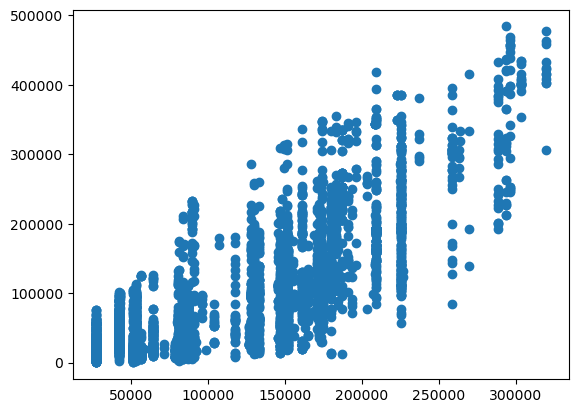

In [59]:
import matplotlib.pyplot as plt
plt.scatter(y_pred, y_test.tolist())

### G.D loss plot

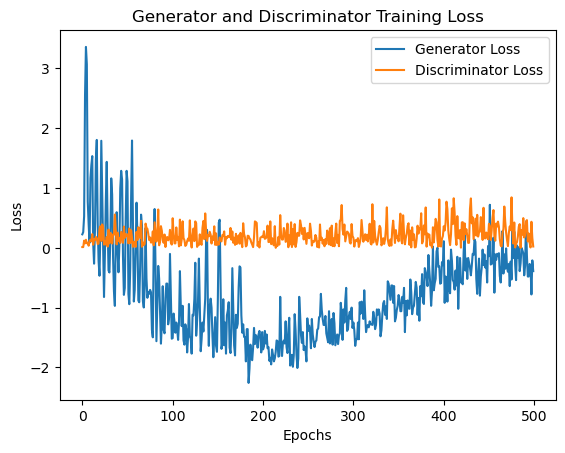

In [8]:
gd_loss = pd.read_csv('gd_loss.csv')
g_loss = gd_loss['G']
d_loss = gd_loss['D']

import matplotlib.pyplot as plt
epochs = range(0,500)
# Plot and label the training and validation loss values
plt.plot(epochs, g_loss[0:500], label='Generator Loss')
plt.plot(epochs, d_loss[0:500], label='Discriminator Loss')
 
# Add in a title and axes labels
plt.title('Generator and Discriminator Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
 
# Display the plot
plt.legend(loc='best')
plt.show()